In [ ]:
# --- Common imports and paths ---
import os
import pandas as pd
import numpy as np
import torch
import joblib

# ML / preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Paths (same as project)
PROCESSED_CSV = "./data/processed/processed_sample_200k.csv"
MODEL_PTH = "./models/torch_mlp.pth"
PREPROCESSOR_JOBLIB = "./models/preprocessor.joblib"
METRICS_JOBLIB = "./models/supervised_metrics.joblib"
DISAGREE_CSV = "./analysis/policy_disagreements_sample.csv"


In [11]:
# 4 - Train supervised MLP (quick prototype)
# Load processed
proc = pd.read_csv(PROCESSED_CSV)
X = proc.drop(columns=['target']).values.astype(np.float32)
y = proc['target'].values.astype(np.int64)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Torch dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)

# Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.2),
            nn.Linear(256,128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.2),
            nn.Linear(128,1), nn.Sigmoid()
        )
    def forward(self,x): return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(X.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# Training loop (small number of epochs for prototype; increase later)
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running_loss += loss.item() * xb.size(0)
    running_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} loss={running_loss:.4f}")
    # optional: evaluation per epoch

# Evaluate
model.eval()
probs = []
trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p = model(xb).cpu().numpy().ravel()
        probs.append(p); trues.append(yb.numpy().ravel())
probs = np.concatenate(probs); trues = np.concatenate(trues)
auc = roc_auc_score(trues, probs)
pred_labels = (probs >= 0.5).astype(int)
f1 = f1_score(trues, pred_labels)
print("Supervised results -> AUC: {:.4f}, F1: {:.4f}".format(auc, f1))

# Save model and metrics
torch.save(model.state_dict(), MODEL_PTH)
joblib.dump({'auc':auc, 'f1':f1}, METRICS_JOBLIB)
print("Saved model to", MODEL_PTH)


Epoch 1/10 loss=0.5731
Epoch 2/10 loss=0.4820
Epoch 3/10 loss=0.4778
Epoch 4/10 loss=0.4737
Epoch 5/10 loss=0.4583
Epoch 6/10 loss=0.4487
Epoch 7/10 loss=0.4468
Epoch 8/10 loss=0.4453
Epoch 9/10 loss=0.4443
Epoch 10/10 loss=0.4438
Supervised results -> AUC: 0.7001, F1: 0.0025
Saved model to ./models/torch_mlp.pth


In [16]:
# --- Robust evaluation cell (replace current Cell 7 with this) ---
import torch, torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
import joblib, os

MODEL_PTH = "./models/torch_mlp.pth"
PROCESSED_CSV = "./data/processed/processed_sample_200k.csv"
BATCH_SIZE = 2048

# Load processed data
df = pd.read_csv(PROCESSED_CSV)
if 'target' not in df.columns:
    raise ValueError("Processed CSV must contain 'target' column.")
X = df.drop(columns=['target']).values.astype(np.float32)
y = df['target'].values.astype(int)

# Inspect checkpoint to get expected input dim
state = torch.load(MODEL_PTH, map_location='cpu')
try:
    ckpt_in_dim = state['net.0.weight'].shape[1]
except Exception:
    # fallback: try to infer input dim from first linear named differently
    # print available keys for debugging
    print("Checkpoint keys:", list(state.keys())[:20])
    raise RuntimeError("Couldn't read checkpoint's first linear layer weight shape. Check model format.")

print("Checkpoint expects input_dim =", ckpt_in_dim, "; processed CSV has input_dim =", X.shape[1])

# Define MLP factory that matches training architecture
def make_mlp(input_dim):
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.2),
                nn.Linear(128, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)
    return MLP(input_dim)

# If dims differ, prefer to create model with ckpt_in_dim and transform data accordingly (if preprocessor exists)
if X.shape[1] != ckpt_in_dim:
    # try to load preprocessor meta to re-generate matching features
    preproc_path = "./models/preprocessor.joblib"
    if os.path.exists(preproc_path):
        meta = joblib.load(preproc_path)
        if 'preprocessor' in meta and 'numeric_features' in meta and 'categorical_features' in meta:
            print("Detected mismatch: trying to re-create X using stored preprocessor and raw sampled CSV.")
            RAW_SAMPLE = "./data/sampled/accepted_sample_200k.csv"
            if os.path.exists(RAW_SAMPLE):
                raw = pd.read_csv(RAW_SAMPLE, low_memory=False)
                required_cols = meta['numeric_features'] + meta['categorical_features']
                if all(c in raw.columns for c in required_cols):
                    X_fixed = meta['preprocessor'].transform(raw[required_cols])
                    print("Transformed raw sample -> shape", X_fixed.shape)
                    X = X_fixed.astype(np.float32)
                else:
                    raise RuntimeError("Raw sample missing columns required by saved preprocessor.")
            else:
                raise RuntimeError("Raw sampled CSV not found at {}. Cannot re-create features.".format(RAW_SAMPLE))
        else:
            raise RuntimeError("preprocessor.joblib found but does not contain expected keys.")
    else:
        # fallback: inform user and recommend retrain
        raise RuntimeError(f"Input dim mismatch (ckpt {ckpt_in_dim} vs CSV {X.shape[1]}). Either restore original preprocessor or retrain the model.")

# Build model with checkpoint input dim (after possible fix above X.shape[1] should == ckpt_in_dim)
input_dim = X.shape[1]
model = make_mlp(input_dim)
model.load_state_dict(state)   # will succeed if dims match
model.eval()

# Move to device and predict in batches
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
probs = []
with torch.no_grad():
    for i in range(0, X.shape[0], BATCH_SIZE):
        xb = torch.tensor(X[i:i+BATCH_SIZE], dtype=torch.float32).to(device)
        p = model(xb).cpu().numpy().ravel()
        probs.append(p)
probs = np.concatenate(probs)

# Metrics
auc = roc_auc_score(y, probs)
pred_labels = (probs >= 0.5).astype(int)
f1 = f1_score(y, pred_labels)
print(f"AUC: {auc:.4f}   F1 (thr=0.5): {f1:.4f}")

# Attach predictions to dataframe for downstream analysis and save a copy
df['pred_prob'] = probs
df['pred_label_0.5'] = pred_labels
out_eval_path = "./analysis/supervised_predictions.csv"
os.makedirs(os.path.dirname(out_eval_path), exist_ok=True)
df.to_csv(out_eval_path, index=False)
print("Saved predictions to", out_eval_path)

# Ready for comparison with RL policy (if available)


C:\Users\HP\AppData\Local\Temp\ipykernel_3536\253813.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PTH, map_location='cpu')


Checkpoint expects input_dim = 137 ; processed CSV has input_dim = 137
AUC: 0.6991   F1 (thr=0.5): 0.0044
Saved predictions to ./analysis/supervised_predictions.csv


In [17]:
# Detailed metrics + confusion matrix
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

preds_df = pd.read_csv("./analysis/supervised_predictions.csv")
y = preds_df['target'].values
probs = preds_df['pred_prob'].values

# metrics at 0.5
labels_05 = (probs >= 0.5).astype(int)
print("At threshold 0.5:")
print("Precision:", precision_score(y, labels_05, zero_division=0))
print("Recall:", recall_score(y, labels_05, zero_division=0))
print("F1:", (2 * precision_score(y, labels_05, zero_division=0) * recall_score(y, labels_05, zero_division=0)) /
                 (precision_score(y, labels_05, zero_division=0) + recall_score(y, labels_05, zero_division=0) + 1e-12))
print("Confusion matrix:\n", confusion_matrix(y, labels_05))

# Basic class balance
neg, pos = np.bincount(y)
print("\nClass distribution: negatives =", neg, " positives =", pos)


At threshold 0.5:
Precision: 0.5642857142857143
Recall: 0.002204917804013509
F1: 0.004392671467088913
Confusion matrix:
 [[164110     61]
 [ 35750     79]]

Class distribution: negatives = 164171  positives = 35829


In [18]:
# Sweep thresholds to maximize F1
from sklearn.metrics import f1_score

thresholds = np.linspace(0.0, 1.0, 101)
f1s = []
for t in thresholds:
    lab = (probs >= t).astype(int)
    f1s.append(f1_score(y, lab, zero_division=0))

best_idx = np.argmax(f1s)
best_t = thresholds[best_idx]
best_f1 = f1s[best_idx]
print("Best threshold by F1:", best_t, " => F1:", best_f1)

# Show precision/recall at best threshold
from sklearn.metrics import precision_score, recall_score
best_lab = (probs >= best_t).astype(int)
print("Precision @best:", precision_score(y, best_lab, zero_division=0))
print("Recall @best:", recall_score(y, best_lab, zero_division=0))


Best threshold by F1: 0.19  => F1: 0.39346316219528804
Precision @best: 0.2915792023252059
Recall @best: 0.6047894163945408


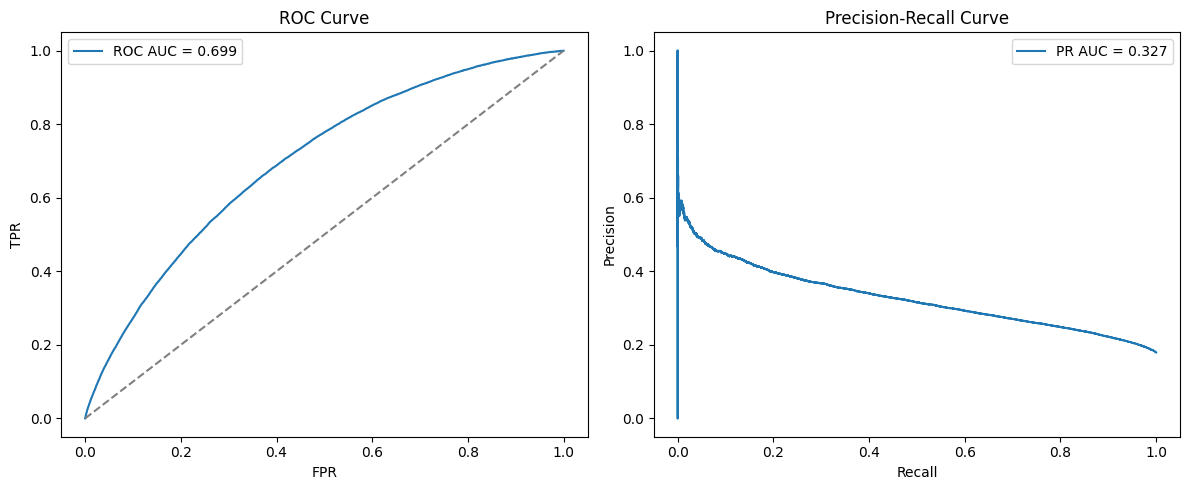

In [19]:
# ROC and PR plots
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, _ = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y, probs)
pr_auc = auc(rec, prec)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
plt.tight_layout()
plt.show()
